In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 

pd.set_option('display.max_columns', None)

In [2]:
class DataImputation(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    

    def __init__(self, excluded_columns):
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.excluded_columns = excluded_columns

    def fit(self, X, y=None):
        help_list = list(X.select_dtypes(exclude='object').columns)
        self.num_cols = [x for x in help_list if x not in self.excluded_columns]
        self.dict_num = {col: X[col].median() for col in self.num_cols}
        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()
        for col in self.num_cols:
            if df[col].isna().sum() > 0:
                df.loc[df[col].isna(), col] = self.dict_num[col]

        self.features = df.columns.values
        return df
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [3]:
class FeatureEngineer(TransformerMixin, BaseEstimator):  
    """Generates new features."""
    
    def __init__(self, dict_lag):
        """Initalizes the attributes."""
        self.features = []
        self.dict_lag = dict_lag
    
    def fit(self, X, y=None):
        """DocString  """
        df = X.copy()
        return self
    
    def transform(self, X, y=None):
        """Generate new columns. """        
        
        df = pd.DataFrame.from_dict({'date':X.index})
        df = df.set_index('date')
        for col in self.dict_lag.keys(): 
            lags = self.dict_lag[col]
            for lag in lags:
                if lag > 0:
                    df[col + '_lag_by_' + str(lag)] = X.loc[:, col ].shift(lag, fill_value = X[col].tolist()[0])

                else:
                    df[col ] = X.loc[:, col ]

        self.features = df.columns.values
        return df
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features


In [5]:
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1)
df

C:\Users\judit\AppData\Local\Temp\ipykernel_28636\2635773066.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1)


,Betriebe_WZ08-10,Betriebe_ep_WZ08-10,Beschäftigte_WZ08-10,Beschäftigte_ep_WZ08-10,Geleistete Arbeitsstunden_WZ08-10,Geleistete Arbeitsstunden_ep_WZ08-10,Bruttolohn- und -gehaltssumme_WZ08-10,Bruttolohn- und -gehaltssumme_ep_WZ08-10,Umsatz_WZ08-10,Umsatz_ep_WZ08-10,Inlandsumsatz_WZ08-10,Inlandsumsatz_ep_WZ08-10,Auslandsumsatz_WZ08-10,Auslandsumsatz_ep_WZ08-10,Auslandsumsatz mit der Eurozone_WZ08-10,Auslandsumsatz mit der Eurozone_ep_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-10,Betriebe_WZ08-108,Betriebe_ep_WZ08-108,Beschäftigte_WZ08-108,Beschäftigte_ep_WZ08-108,Geleistete Arbeitsstunden_WZ08-108,Geleistete Arbeitsstunden_ep_WZ08-108,Bruttolohn- und -gehaltssumme_WZ08-108,Bruttolohn- und -gehaltssumme_ep_WZ08-108,Umsatz_WZ08-108,Umsatz_ep_WZ08-108,Inlandsumsatz_WZ08-108,Inlandsumsatz_ep_WZ08-108,Auslandsumsatz_WZ08-108,Auslandsumsatz_ep_WZ08-108,Auslandsumsatz mit der Eurozone_WZ08-108,Auslandsumsatz mit der Eurozone_ep_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-108,Betriebe_WZ08-1082,Betriebe_ep_WZ08-1082,Beschäftigte_WZ08-1082,Beschäftigte_ep_WZ08-1082,Geleistete Arbeitsstunden_WZ08-1082,Geleistete Arbeitsstunden_ep_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,Bruttolohn- und -gehaltssumme_ep_WZ08-1082,Umsatz_WZ08-1082,Umsatz_ep_WZ08-1082,Inlandsumsatz_WZ08-1082,Inlandsumsatz_ep_WZ08-1082,Auslandsumsatz_WZ08-1082,Auslandsumsatz_ep_WZ08-1082,Auslandsumsatz mit der Eurozone_WZ08-1082,Auslandsumsatz mit der Eurozone_ep_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1082,Betriebe_WZ08-1083,Betriebe_ep_WZ08-1083,Beschäftigte_WZ08-1083,Beschäftigte_ep_WZ08-1083,Geleistete Arbeitsstunden_WZ08-1083,Geleistete Arbeitsstunden_ep_WZ08-1083,Bruttolohn- und -gehaltssumme_WZ08-1083,Bruttolohn- und -gehaltssumme_ep_WZ08-1083,Umsatz_WZ08-1083,Umsatz_ep_WZ08-1083,Inlandsumsatz_WZ08-1083,Inlandsumsatz_ep_WZ08-1083,Auslandsumsatz_WZ08-1083,Auslandsumsatz_ep_WZ08-1083,Auslandsumsatz mit der Eurozone_WZ08-1083,Auslandsumsatz mit der Eurozone_ep_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1083,ErzPr_Nahrungsmittel und Futtermittel,ErzPr_Sonstige Nahrungsmittel (ohne Getränke),ErzPr_Süßwaren (ohne Dauerbackwaren),ErzPr_Schokoladen und andere Süßwaren,"ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg","ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg",ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade),"ErzPr_Kaffee und Tee, Kaffee-Ersatz","ErzPr_Kaffee und Tee, Kaffee-Ersatz.1","ErzPr_Kaffee, entkoffeiniert oder geröstet","ErzPr_Kaffeemittel m. -geh.,Auszüge,Essenz.,Konzentrate","ErzPr_Grüner Tee (n. ferment.), schwarzer Tee (ferment.)",ErzPr_Kräutertees,EinfPr_Nahrungsmittel und Futtermittel,EinfPr_Sonstige Nahrungsmittel (ohne Getränke),EinfPr_Süßwaren (ohne Dauerbackwaren),"EinfPr_Kaffee und Tee, Kaffee-Ersatz",VPI_Nahrungsmittel und alkoholfreie Getränke,VPI_Nahrungsmittel,"VPI_Zucker, Marmelade, Honig und andere Süßwaren",VPI_Schokoladen,VPI_Süßwaren,VPI_Alkoholfreie Getränke,"VPI_Kaffee, Tee und Kakao",VPI_Kaffee und Ähnliches,VPI_Tee und teeähnliche Erzeugnisse,VPI_Kakaopulver oder Ähnliches,"Wert der zum Absatz bestimmten Produktion_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Wert der zum Absatz bestimmten Produktion_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge der zum Absatz bestimmten Produktion_stueck_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge de

In [ ]:
number_train = 70
dict_lag = {df.columns.values[76]: [1,2,3], 
            df.columns.values[93]: [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)
df_train_transf

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


,"ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg_lag_by_1","ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg_lag_by_2","ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg_lag_by_3",VPI_Süßwaren
date,,,,
2019-01-31,95.6,95.6,95.6,100.1
2019-02-28,95.6,95.6,95.6,99.2
2019-03-31,96.1,95.6,95.6,99.6
2019-04-30,95.9,96.1,95.6,99.6
2019-05-31,97.4,95.9,96.1,99.0
...,...,...,...,...
2024-06-30,304.8,299.6,237.1,128.0
2024-07-31,344.0,304.8,299.6,129.9
2024-08-31,311.3,344.0,304.8,130.6


<Axes: >

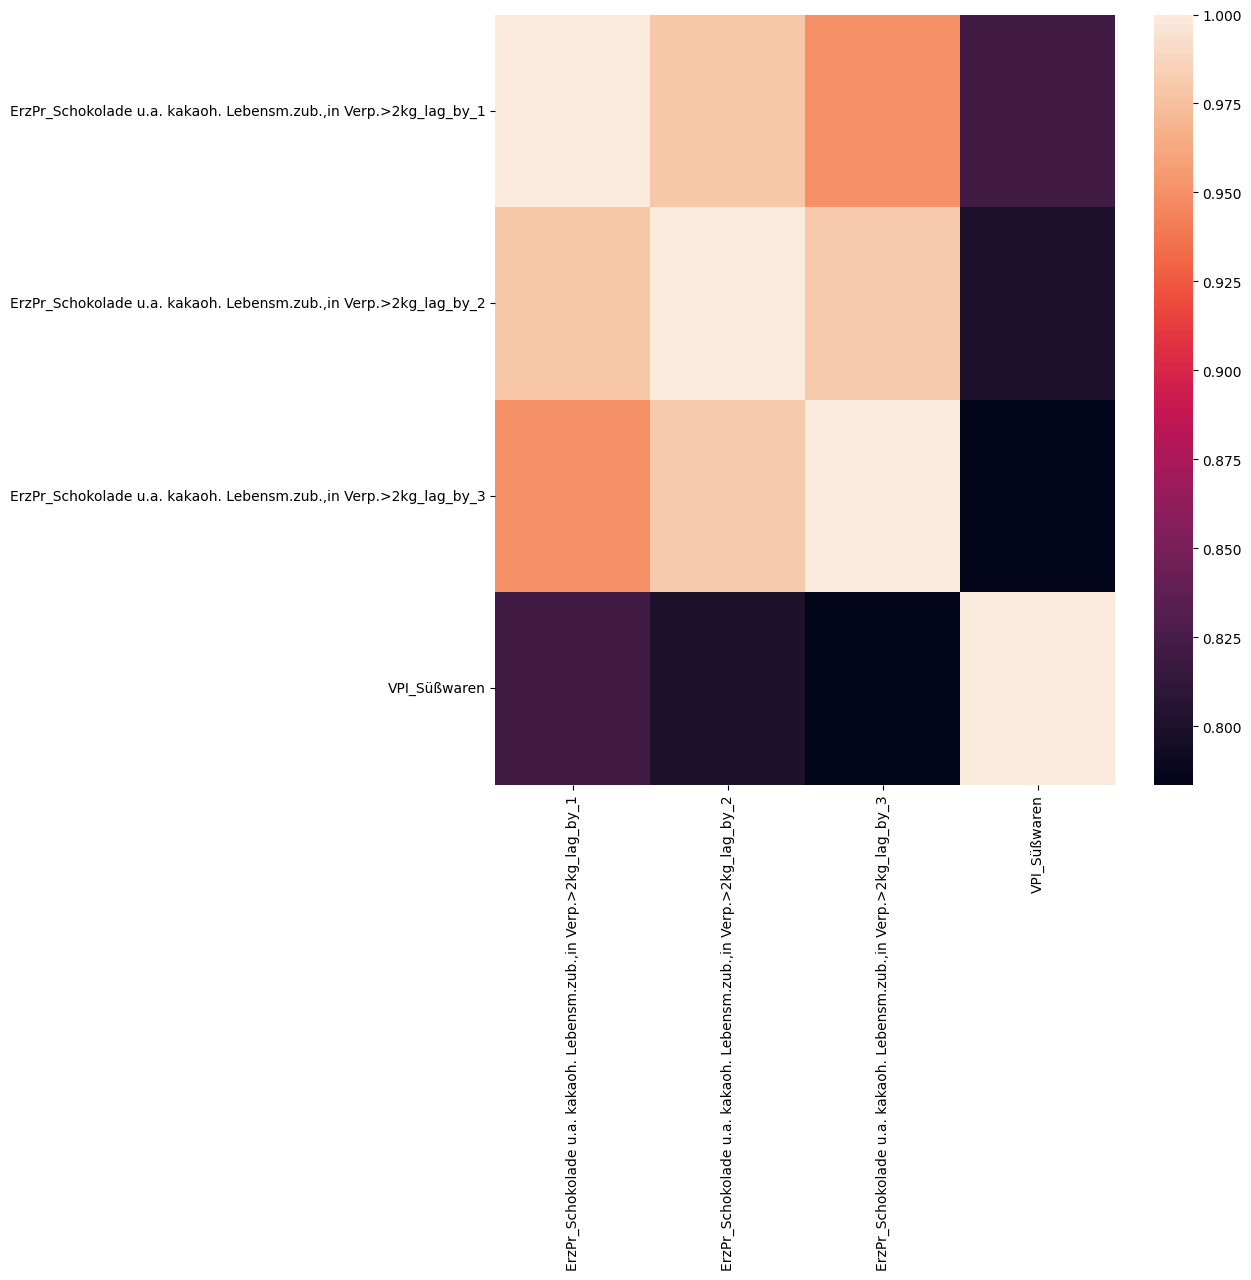

In [9]:
corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Why including lag is sensible

In [31]:
df.columns.values[143]

'Wert der zum Absatz bestimmten Produktion_Kaffee, geröstet'

In [32]:
demand = (df.iloc[:, 44])
price = df.iloc[:, 121]
demand_change = demand.pct_change()
price_change = price.pct_change()
elasticity = demand_change / price_change
df['elasticity'] = elasticity

demand_coffee = (df.iloc[:, 62])
price_coffee = df.iloc[:, 143]
demand_change_coffee = demand_coffee.pct_change()
price_change_coffee = price_coffee.pct_change()
elasticity_coffee = demand_change_coffee / price_change_coffee
df['elasticity_coffee'] = elasticity_coffee

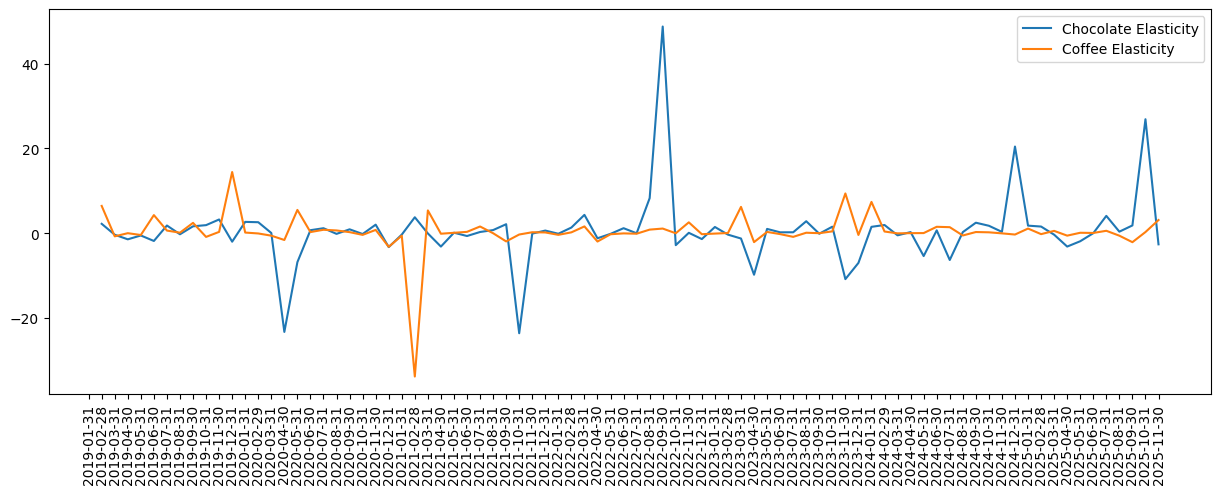

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(df.index,df.elasticity.values, label = 'Chocolate Elasticity')
ax.plot(df.index,df.elasticity_coffee.values, label = 'Coffee Elasticity')
plt.xticks(rotation=90)
ax.legend();

### Global cacoa prices

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

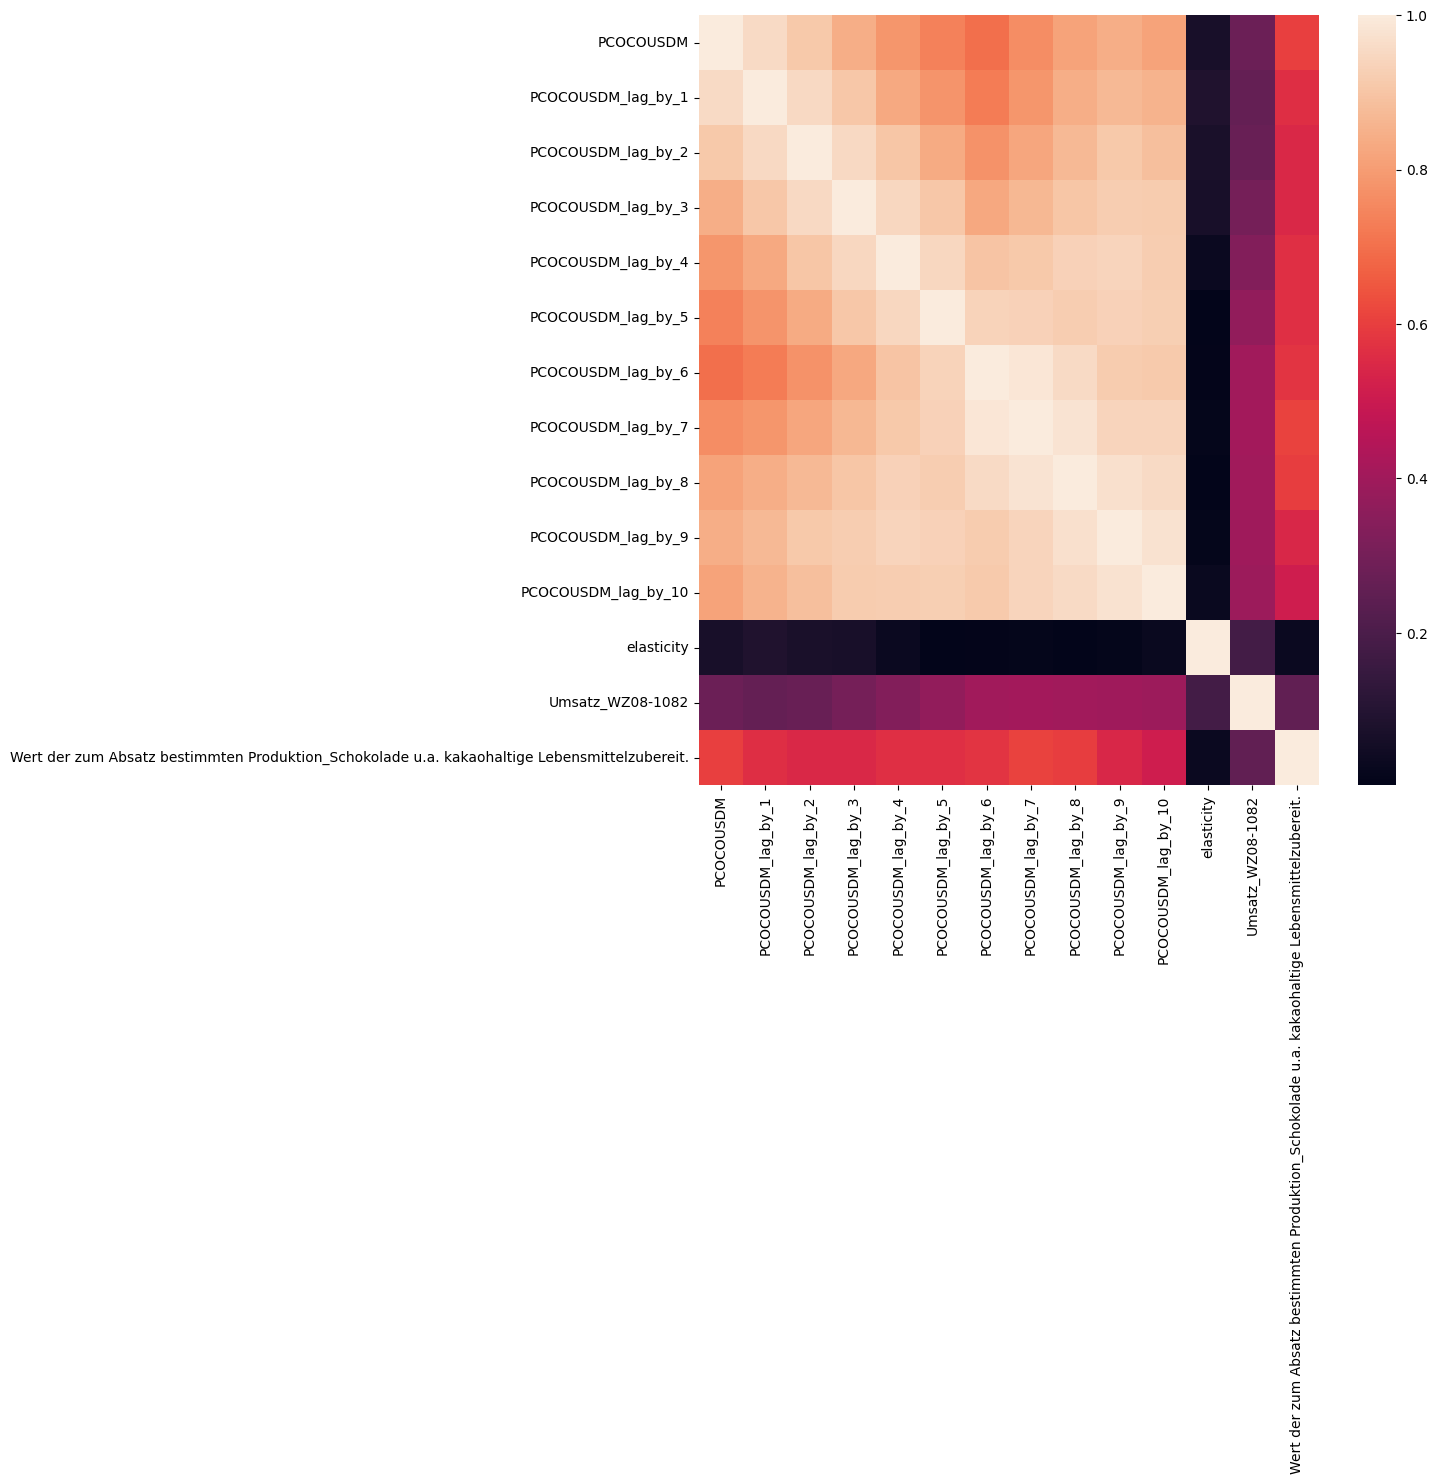

In [23]:
number_train = 70
dict_lag = {df.columns.values[165]: [0,1,2,3,4,5,6,7,8,9,10], 
            df.columns.values[170]: [0], 
            df.columns.values[44]: [0], 
            df.columns.values[121]: [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

### Modelez share

In [25]:
df.columns.values[168]

'Mondelez'

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

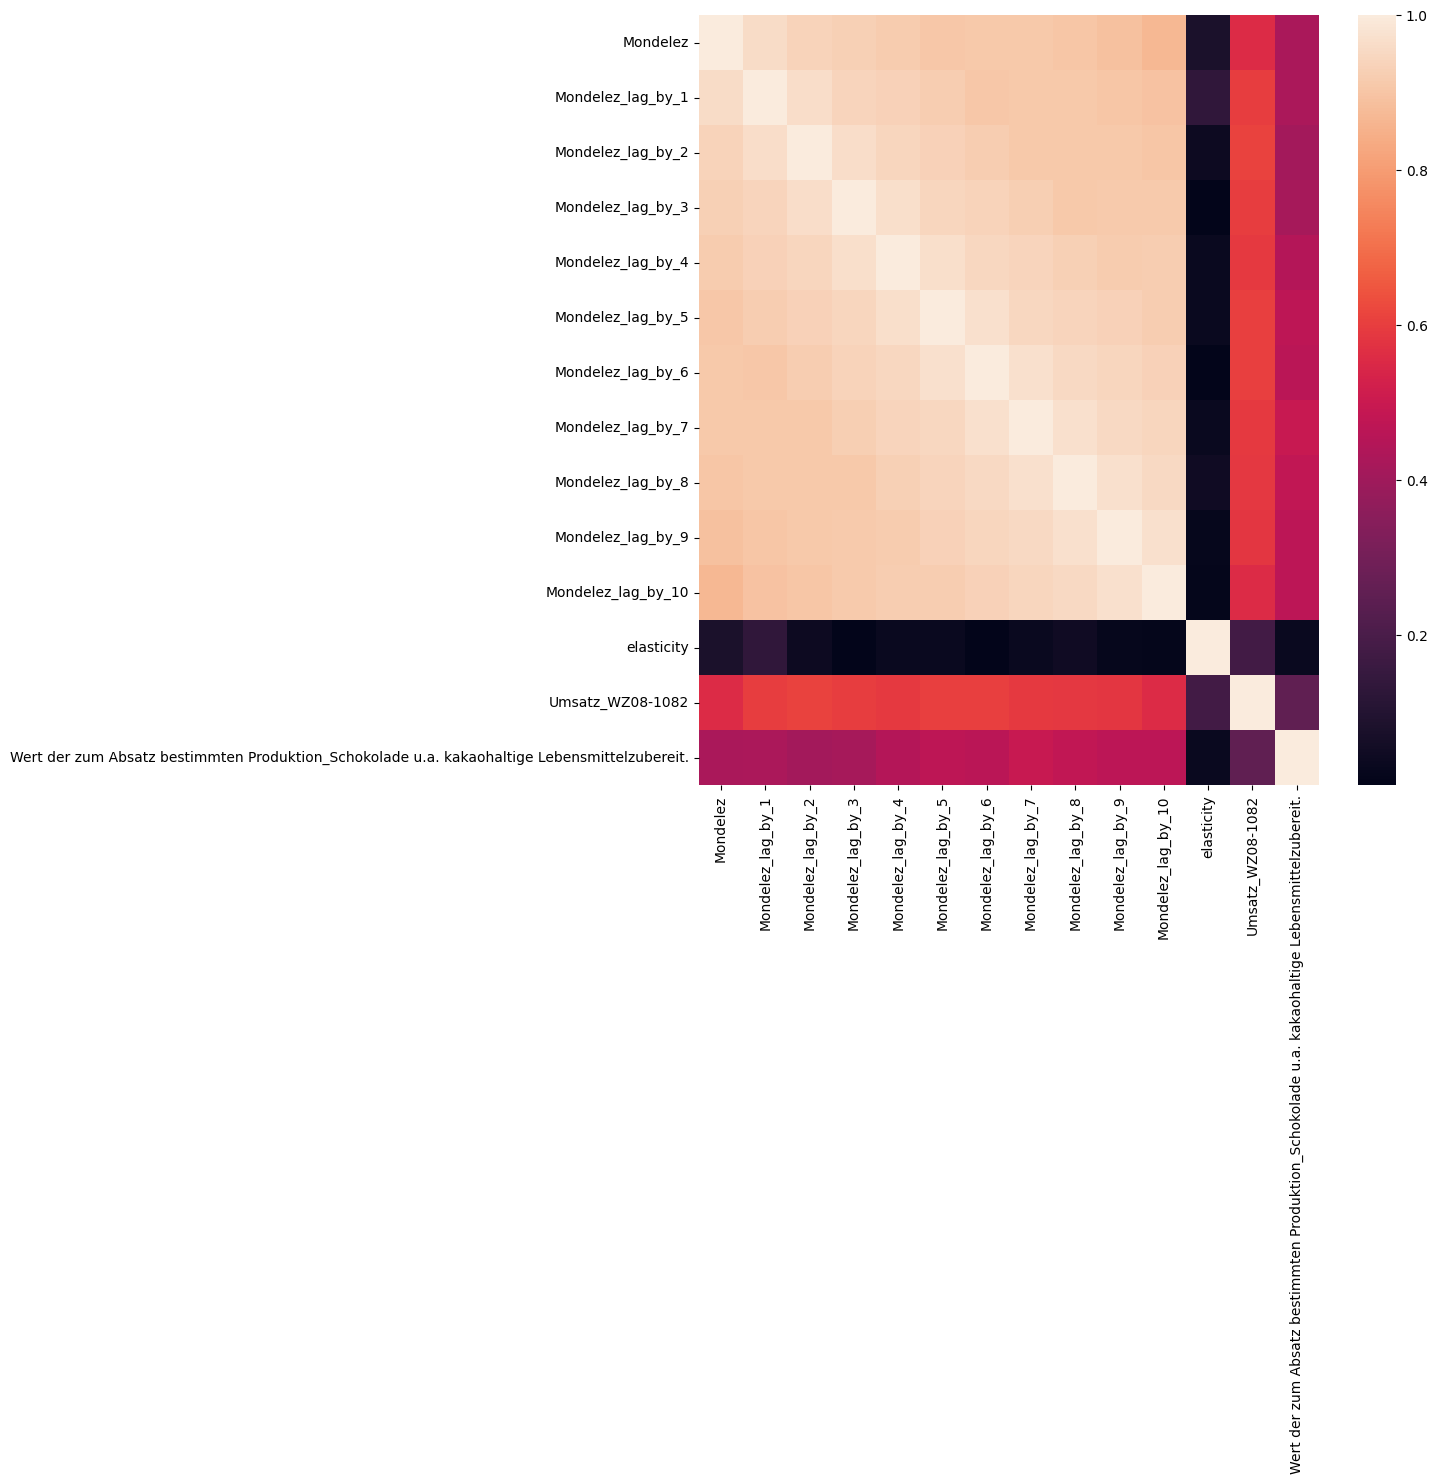

In [26]:
number_train = 70
dict_lag = {df.columns.values[168]: [0,1,2,3,4,5,6,7,8,9,10], 
            df.columns.values[170]: [0], 
            df.columns.values[44]: [0], 
            df.columns.values[121]: [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

### global coffee price

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

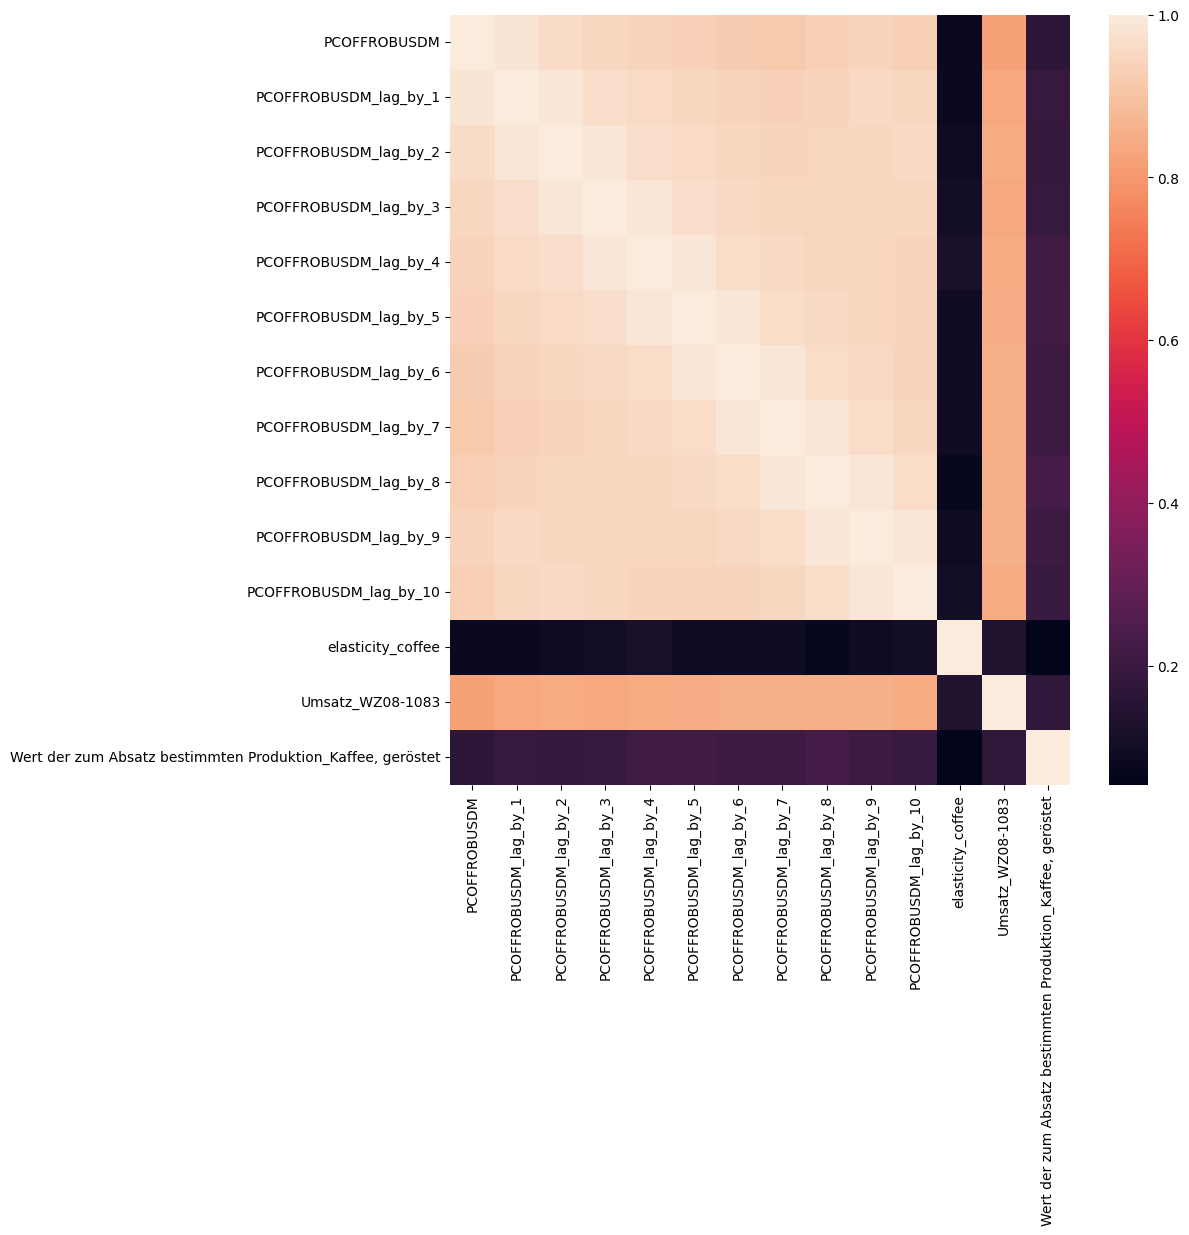

In [36]:
number_train = 70
dict_lag = {df.columns.values[166]: [0,1,2,3,4,5,6,7,8,9,10], 
            df.columns.values[171]: [0], 
            df.columns.values[62]: [0], 
            df.columns.values[143]: [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)